In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [2]:
anr_tag = 'NOAK'
wacc = utils.WACC
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'

In [3]:
save_fig_path = f'./results/process_heat_anr_{anr_tag}_h2'

In [4]:
df = pd.read_excel(results_path, sheet_name='process_heat')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [5]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [6]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df['Cum dem (t/day)'] = df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()

### Compute cumulative number of viable steel plants and ANR modules

In [7]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR plants count'] = df.index+1
df.head(5)

,id,state,H2 Dem. (kg/day),Heat Dem. (MJ/year),Net Revenues ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),...,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR plants count
0,1000588,IN,153100.342414,7.928485e+09,-9.060527e+07,0,0,154.0,1.444336e+07,2.516664e+07,...,1,12.056984,300,iMSR,300,0.3,153.100342,2.238134,1,1
1,1007177,OH,150959.177564,7.817602e+09,-8.990793e+07,0,0,151.0,1.416200e+07,2.516664e+07,...,1,12.133885,300,iMSR,300,0.6,304.059520,4.444966,2,2
2,1000418,IN,433411.991729,2.244476e+10,-2.641191e+08,0,0,434.0,4.070402e+07,7.549992e+07,...,3,12.415388,300,iMSR,900,1.5,737.471512,10.780902,5,3
3,1005198,TX,141178.307699,7.311088e+09,-8.714032e+07,0,0,142.0,1.331791e+07,2.516664e+07,...,1,12.575133,300,iMSR,300,1.8,878.649819,12.844750,6,4
4,1000630,VA,177254.463397,9.179335e+09,-1.101801e+08,0,0,178.0,1.609177e+07,3.189464e+07,...,2,12.663898,200,PBR-HTGR,400,2.2,1055.904283,15.435986,8,5


### Compute average carbon intensity

In [8]:
mmbtu_to_mj = 1055.06 #MJ/MMBtu
df['C intensity (tCO2/MMBtu)'] = df['Ann. CO2 emissions (kgCO2eq/year)']/(1e3*df['Heat Dem. (MJ/year)']/mmbtu_to_mj)
df.head(5)
print('Average carbon intensity (tCO2/MMBtu) for BAU case: {}'.format(df['C intensity (tCO2/MMBtu)'].mean()))

Average carbon intensity (tCO2/MMBtu) for BAU case: 0.0020325739079027007


### Compute avoided carbon emissions 

In [9]:
demand_heat_df = pd.read_excel('./h2_demand_industry_heat.xlsx', sheet_name='max')
demand_heat_df = demand_heat_df[['FACILITY_ID', 'MMTCO2E']]
demand_heat_df.head(3)

,FACILITY_ID,MMTCO2E
0,1000022,0.004963
1,1000029,0.033338
2,1000056,0.041385


In [10]:
df = df.merge(demand_heat_df, left_on='id', right_on='FACILITY_ID')
df.head(3)

,id,state,H2 Dem. (kg/day),Heat Dem. (MJ/year),Net Revenues ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),...,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR plants count,C intensity (tCO2/MMBtu),FACILITY_ID,MMTCO2E
0,1000588,IN,153100.342414,7.928485e+09,-9.060527e+07,0,0,154.0,1.444336e+07,2.516664e+07,...,iMSR,300,0.3,153.100342,2.238134,1,1,0.001922,1000588,0.399145
1,1007177,OH,150959.177564,7.817602e+09,-8.990793e+07,0,0,151.0,1.416200e+07,2.516664e+07,...,iMSR,300,0.6,304.059520,4.444966,2,2,0.001911,1007177,0.393562
2,1000418,IN,433411.991729,2.244476e+10,-2.641191e+08,0,0,434.0,4.070402e+07,7.549992e+07,...,iMSR,900,1.5,737.471512,10.780902,5,3,0.001913,1000418,1.129939


In [11]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = df.apply(lambda row: row['MMTCO2E']- row['Ann. CO2 emissions (kgCO2eq/year)']/1e9, axis=1)
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(355)


,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,12.056984,0.384701
1,12.133885,0.764102
2,12.415388,1.853337
3,12.575133,2.208082
4,12.663898,2.654106
...,...,...
288,489.817755,17.342852
289,571.346674,17.343298
290,613.152451,17.343707
291,1528.777562,17.343826


### Save clean version of results


In [12]:
df_clean = df[["id", 'state','H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Revenues ($/year)','Breakeven price ($/MMBtu)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Viable avoided emissions (MMT-CO2/year)']]
df_clean


,id,state,H2 Dem. (kg/day),HTSE,ANR type,# ANR modules,Net Revenues ($/year),Breakeven price ($/MMBtu),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,1000588,IN,153100.342414,154.0,iMSR,1,-9.060527e+07,12.056984,0.384701,0.384701
1,1007177,OH,150959.177564,151.0,iMSR,1,-8.990793e+07,12.133885,0.379400,0.764102
2,1000418,IN,433411.991729,434.0,iMSR,3,-2.641191e+08,12.415388,1.089235,1.853337
3,1005198,TX,141178.307699,142.0,iMSR,1,-8.714032e+07,12.575133,0.354745,2.208082
4,1000630,VA,177254.463397,178.0,PBR-HTGR,2,-1.101801e+08,12.663898,0.446025,2.654106
...,...,...,...,...,...,...,...,...,...,...
288,1006336,AL,233.209349,1.0,Micro,1,-5.606852e+06,489.817755,0.000533,17.342852
289,1005537,KY,199.690785,1.0,Micro,1,-5.600107e+06,571.346674,0.000445,17.343298
290,1006263,MI,185.983880,1.0,Micro,1,-5.597349e+06,613.152451,0.000410,17.343707
291,1002884,TX,74.293726,1.0,Micro,1,-5.574874e+06,1528.777562,0.000118,17.343826


In [13]:
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x)/1e6,1))
df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(-x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean.apply(lambda x: np.round(x['Ann. avoided CO2 emissions (MMT-CO2/year)'],3), axis=1)

df_clean["Breakeven price ($/MMBtu)"] = df_clean.apply(lambda row : np.round(row['Breakeven price ($/MMBtu)'],1), axis=1)
df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df_clean.to_excel(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_4188\2631777298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_4188\2631777298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_4188\2631777298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [14]:

sheet_name = 'process_heat'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      # Check if the sheet exists
      if sheet_name in xls.sheet_names:
          # If the sheet exists, replace the data
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
      else:
          # If the sheet doesn't exist, create a new sheet
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name, index=False)

### Plots

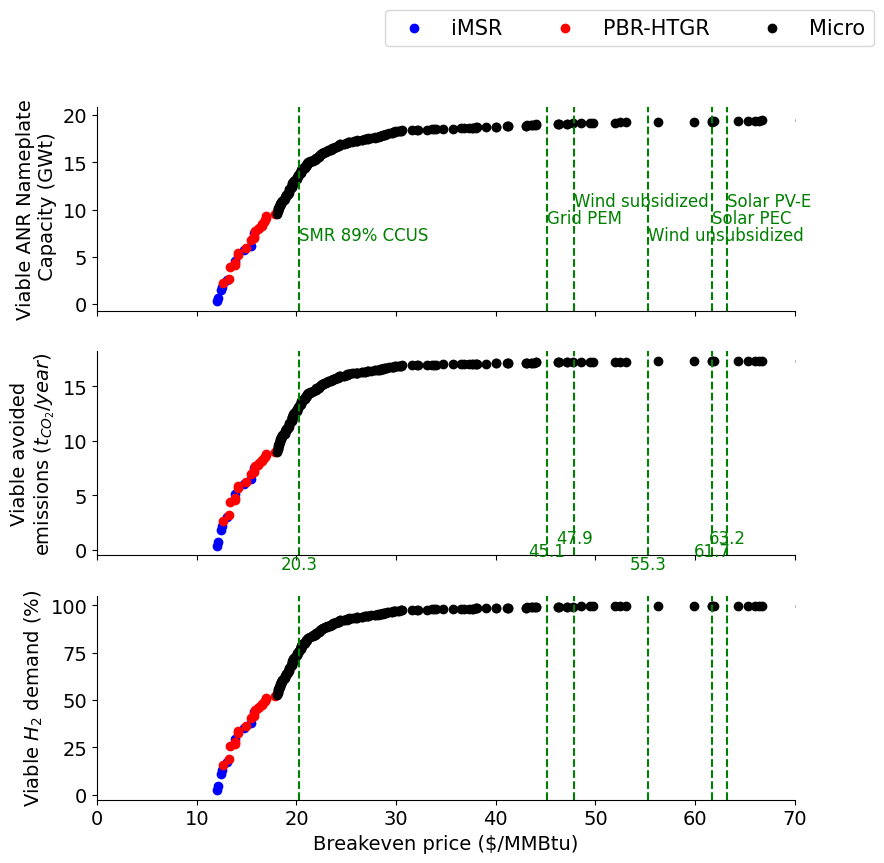

In [15]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    axs[i].set_xlim([0,70])

    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_heat_process.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/3+1.8*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.2*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path+'.png')

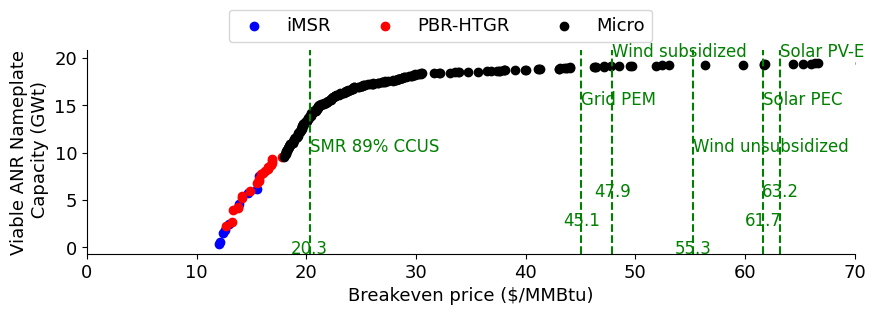

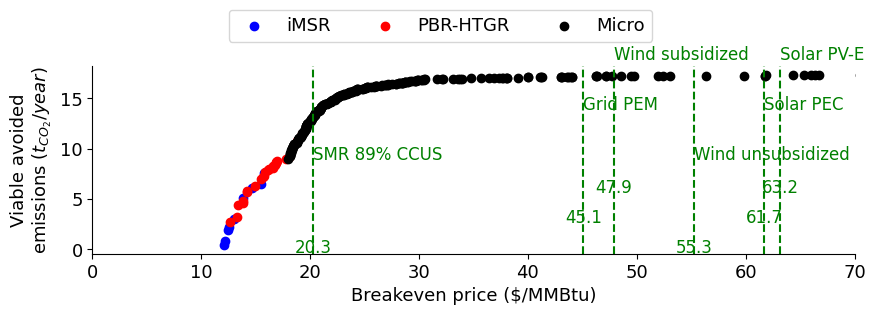

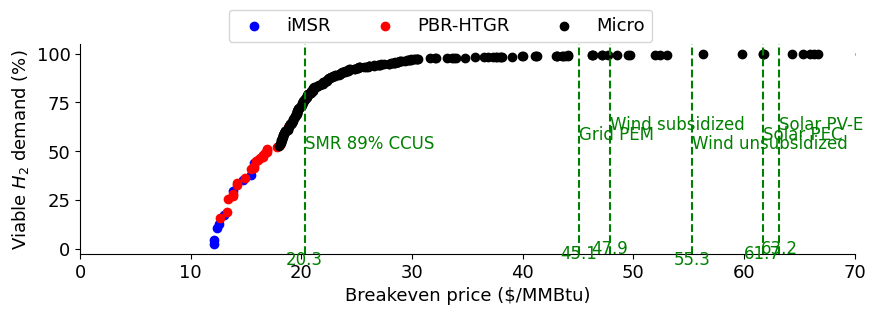

In [16]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWt)': ['Viable ANR Nameplate\n Capacity (GWt)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(9, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_xlim([0,70])

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_heat_process.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+5*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+3*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    
    fig.legend(handles, labels, bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(colors))
    fig.tight_layout()
    fig.savefig(save_fig_path+'_'+save_label+'.png',  bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
